# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import AsynchronousXopt as Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from dask.distributed import Client

import matplotlib.pyplot as plt

import pandas as pd
from concurrent.futures import ThreadPoolExecutor

import os


# Notebook printing output
# from xopt import output_notebook
# output_notebook()

N_CPUS = multiprocessing.cpu_count()
N_CPUS

# directory for data.
os.makedirs("temp", exist_ok=True)

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """

max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 2.4.6.dev5+ga295b108.d20250107
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep=0.1)

96.7 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 3.21 s, sys: 28.5 ms, total: 3.23 s
Wall time: 1min 44s


# Processes

In [6]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.38 s, sys: 146 ms, total: 3.53 s
Wall time: 26.4 s


1000

# Threads

Continue running, this time with threads.

In [7]:
%%time
X = Xopt(YAML)

with ThreadPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.17 s, sys: 49.4 ms, total: 3.22 s
Wall time: 25.5 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [8]:
X = Xopt(YAML)
X.dump("test.yaml")  # Write this input to file
!cat test.yaml

data: null
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [9]:
%%time
!mpirun -n 8 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2, asynchronous=True)
Parallel execution with 8 workers
Enabling async mode


Initialized generator cnsga
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2

            Xopt
________________________________
Version: 2.4.6.dev5+ga295b108.d20250107
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
   

Xopt is done. Max evaluations 1000 reached.


CPU times: user 177 ms, sys: 38.7 ms, total: 216 ms
Wall time: 23.3 s


In [10]:
!tail xopt.log

2025-01-07T15:53:28+0000 - xopt - INFO - Parallel execution with 8 workers
2025-01-07T15:53:28+0000 - xopt - INFO - Enabling async mode
2025-01-07T15:53:28+0000 - xopt.generator - INFO - Initialized generator cnsga
2025-01-07T15:53:28+0000 - xopt.generators.ga.cnsga - INFO - Created toolbox with 2 variables, 2 constraints, and 2 objectives.
2025-01-07T15:53:28+0000 - xopt.generators.ga.cnsga - INFO -     Using selection algorithm: nsga2
2025-01-07T15:53:48+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [11]:
client = Client()
executor = client.get_executor()
client

<Client: 'tcp://127.0.0.1:43429' processes=4 threads=4, memory=15.62 GiB>

In [12]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 6.62 s, sys: 696 ms, total: 7.32 s
Wall time: 29.6 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [13]:
X.data

x1        x2               a        y1        y2         c1  \
4    2.657826  0.680242  dummy_constant  2.657826  0.680242   6.591453   
1    1.358059  1.039605  dummy_constant  1.358059  1.039605   1.976681   
2    0.732522  1.249674  dummy_constant  0.732522  1.249674   1.157109   
3    2.824841  2.820083  dummy_constant  2.824841  2.820083  14.832604   
4    0.030387  2.849451  dummy_constant  0.030387  2.849451   7.021746   
..        ...       ...             ...       ...       ...        ...   
995  0.028453  0.984295  dummy_constant  0.028453  0.984295  -0.119854   
996  0.085762  0.701534  dummy_constant  0.085762  0.701534  -0.463819   
997  0.826509  0.639893  dummy_constant  0.826509  0.639893   0.136482   
998  0.677164  0.806543  dummy_constant  0.677164  0.806543   0.091246   
999  0.610778  0.943615  dummy_constant  0.610778  0.943615   0.360746   

            c2  xopt_runtime  xopt_error  
4     4.688702      0.074174       False  
1     1.027438      0.039557       False  
2     0.616077      0.106800       False  
3    10.787671      0.101759       False  
4     5.740457      0.056913       False  
..         ...           ...         ...  
995   0.456898      0.183301       False  
996   0.212210      0.165566       False  
997   0.126178      0.167689       False  
998   0.125356      0.149389       False  
999   0.209066      0.116201       False  

[1000 rows x 9 columns]

In [14]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df["feasible"]]

x1        x2               a        y1        y2        c1  \
126  0.770030  1.062637  dummy_constant  0.770030  1.062637  0.804201   
127  0.879114  1.039605  dummy_constant  0.879114  1.039605  0.830278   
189  0.950119  0.980121  dummy_constant  0.950119  0.980121  0.766440   
191  0.622281  1.049742  dummy_constant  0.622281  1.049742  0.554200   
194  0.770030  1.062637  dummy_constant  0.770030  1.062637  0.804201   
..        ...       ...             ...       ...       ...       ...   
992  0.820193  1.054236  dummy_constant  0.820193  1.054236  0.824605   
993  0.116947  1.039371  dummy_constant  0.116947  1.039371  0.115980   
997  0.826509  0.639893  dummy_constant  0.826509  0.639893  0.136482   
998  0.677164  0.806543  dummy_constant  0.677164  0.806543  0.091246   
999  0.610778  0.943615  dummy_constant  0.610778  0.943615  0.360746   

           c2  xopt_runtime  xopt_error  feasible_c1  feasible_c2  feasible  
126  0.389477      0.105016       False         True         True      True  
127  0.434901      0.172584       False         True         True      True  
189  0.433123      0.002502       False         True         True      True  
191  0.317169      0.045969       False         True         True      True  
194  0.389477      0.142606       False         True         True      True  
..        ...           ...         ...          ...          ...       ...  
992  0.409701      0.020315       False         True         True      True  
993  0.437651      0.098644       False         True         True      True  
997  0.126178      0.167689       False         True         True      True  
998  0.125356      0.149389       False         True         True      True  
999  0.209066      0.116201       False         True         True      True  

[468 rows x 12 columns]

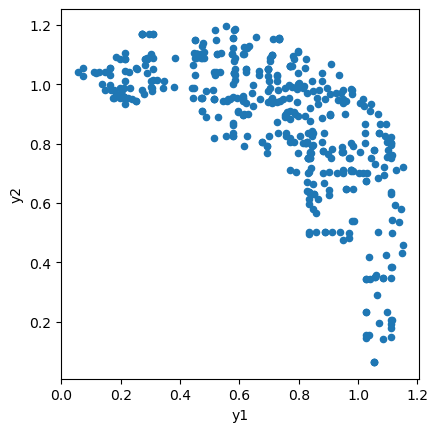

In [15]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

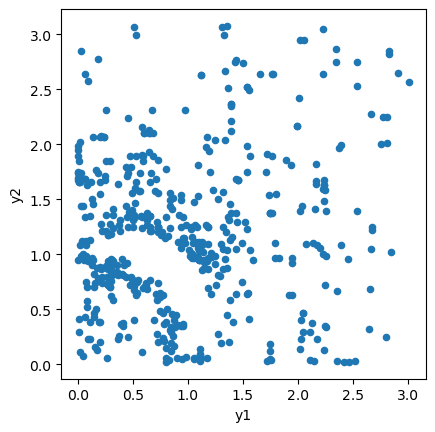

In [16]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

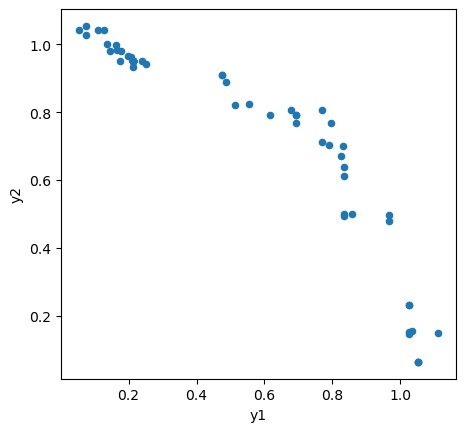

In [17]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

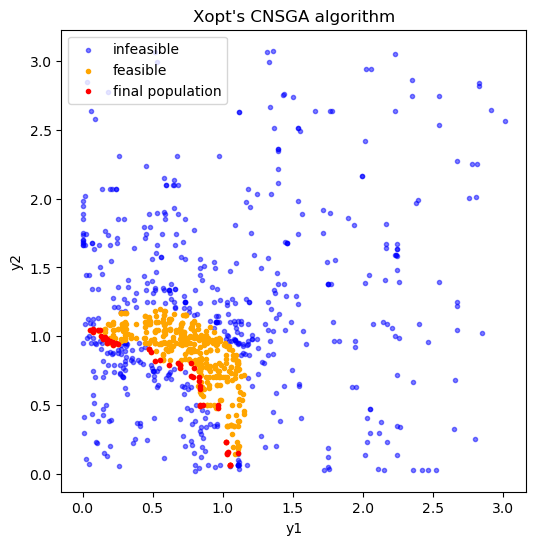

In [18]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title("Xopt's CNSGA algorithm")
plt.legend()

In [19]:
# Cleanup
#!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml